#Simple RNN

##Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import time
import re

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense, Flatten, SimpleRNN, Conv1D,
                                     Bidirectional, GRU, LSTM,
                                     BatchNormalization, Dropout, Input, MaxPooling1D,
                                     Embedding, TextVectorization)
from tensorflow.keras.losses import (CategoricalCrossentropy,
                                     SparseCategoricalCrossentropy)
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("falgunipatel19/biomedical-text-publication-classification")

print("Path to dataset files:", path)

100%|██████████| 55.9M/55.9M [00:03<00:00, 15.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/falgunipatel19/biomedical-text-publication-classification/versions/1


In [3]:
!cp -r /root/.cache/kagglehub/datasets/falgunipatel19/biomedical-text-publication-classification/ /content/

##Exploring the dataset

###functions

In [32]:
def plot_class_distribution(data, target_column="Target"):
    # Get the value counts of the target column
    counts = data[target_column].value_counts()

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the bar plot
    ax1 = sns.barplot(x=counts.index, y=counts.values, ax=axs[0])

    # Annotate the bar plot with the counts
    for i, p in enumerate(ax1.patches):
        ax1.annotate(f'{counts.iloc[i]}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom',
                     fontsize=10)

    # Set titles and labels for the bar plot
    axs[0].set_title('Number of Samples per Class')
    axs[0].set_xlabel('Classes')
    axs[0].set_ylabel('Number of Samples')

    # Plot the pie chart
    axs[1].pie(counts.values,
               autopct="%.1f%%",
               labels=counts.index)
    axs[1].set_title('Distribution of Cancer Types')

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_class_distribution(data)


In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(data, target_column="Target", target_value="Thyroid_Cancer", text_column="Text"):
    # Filter the data based on the target value
    target_text = data[data[target_column] == target_value][text_column].values
    target_text = ' '.join(target_text)

    # Create the word cloud
    plt.figure(figsize=(10, 8))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(target_text)

    # Display the word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {target_value}')
    plt.axis('off')
    plt.show()

# Example usage:
# plot_wordcloud(data)

In [34]:
# Function to plot loss, accuracy and best epoch

def learning_curves_plot(tr_data, start_epoch):
    # Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)

    index_loss = np.argmin(vloss)  # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]

    plt.style.use('fivethirtyeight')

    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

###Working with the dataset

In [4]:
data = pd.read_csv("/content/biomedical-text-publication-classification/versions/1/alldata_1_for_kaggle.csv"
                   , encoding="latin1")
data.head()

,Unnamed: 0,0,a
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [5]:
#Checking for zeros, missign information, duplicates, and excluding this informations
data.isna().sum()
data.duplicated().sum()
data = data.drop('Unnamed: 0', axis =1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7570 non-null   object
 1   a       7570 non-null   object
dtypes: object(2)
memory usage: 118.4+ KB


In [6]:
data = data.rename(columns={"0": "Target", "a":"Text"})
data["Text"].iloc[0]

"Thyroid surgery in  children in a single institution from Osama Ibrahim Almosallama Ali Aseerib Ahmed Alhumaida Ali S AlZahranic Saif Alsobhib Saud AlShanafeybFrom the  aDepartment of Surgery College of Medicine Qassim University Buraidah Al Qassim Saudi Arabia  bDepartment of Surgery King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia cDepartment of Medicine King Faisal Specialist Hospital and Research Center Riyadh Saudi Arabia Correspondence   Dr  Osama Ibrahim  Almosallam  Department of  Surgery  College  of  Medicine Qassim  University  PO  Box   Buraidah  Al  Qassim   Saudi  Arabia  osama_iaahotmailcom ORCID orcid0000000290367564        Citation  Almosallam OI Aseeri A Alhumaid A AlZahrani AS Alsobhi S AlShanafey S Thyroid surgery in  children  in  a  single  institution  from   Ann  Saudi  Med         Received January  Accepted May  Published August  Copyright Copyright   Annals of Saudi Medicine Saudi Arabia This is an   access  under the Creative Commons A

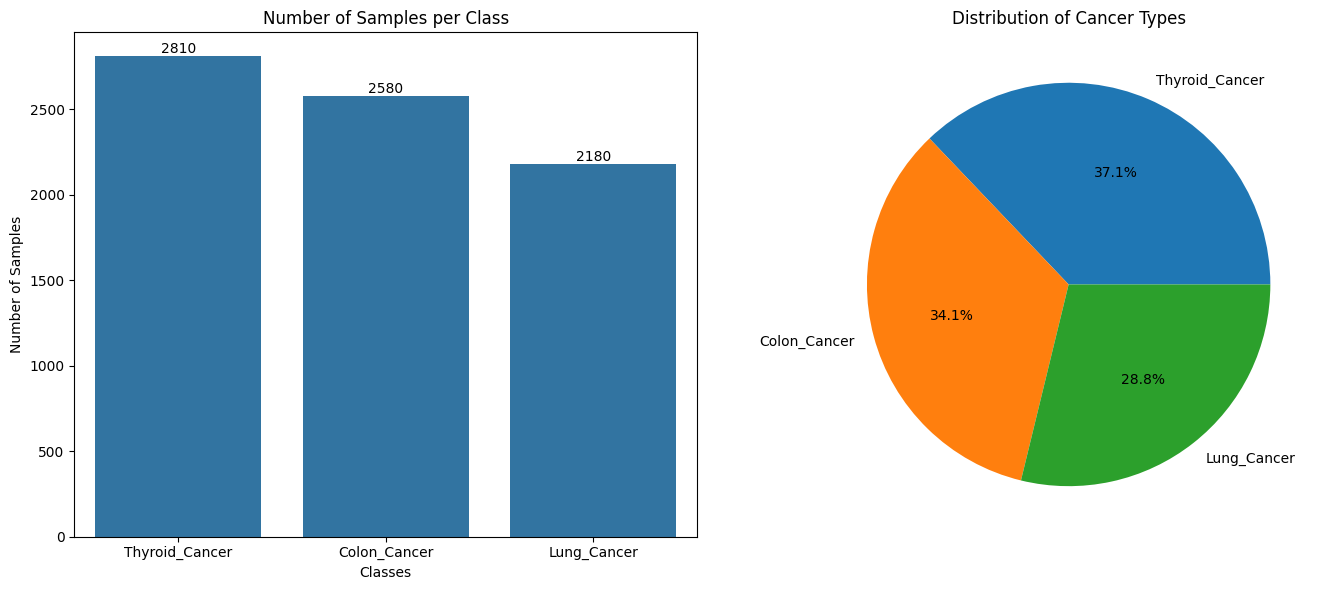

In [10]:
#Plotting data distributions
plot_class_distribution(data)

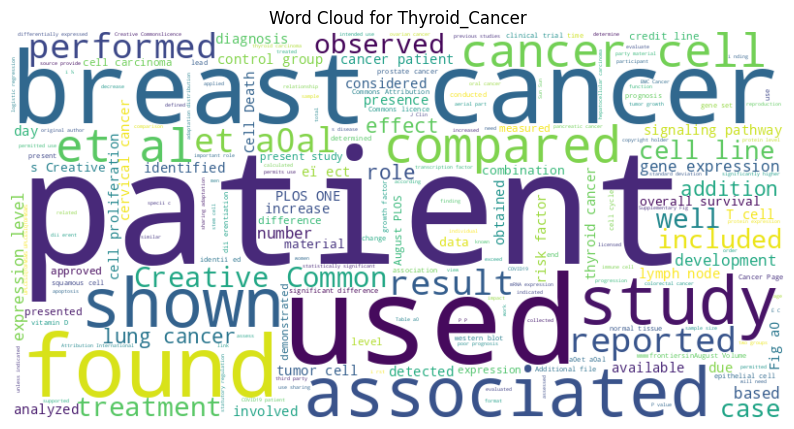

In [13]:
#Important words related to thyroid cancer
plot_wordcloud(data, target_column="Target", target_value="Thyroid_Cancer", text_column="Text")

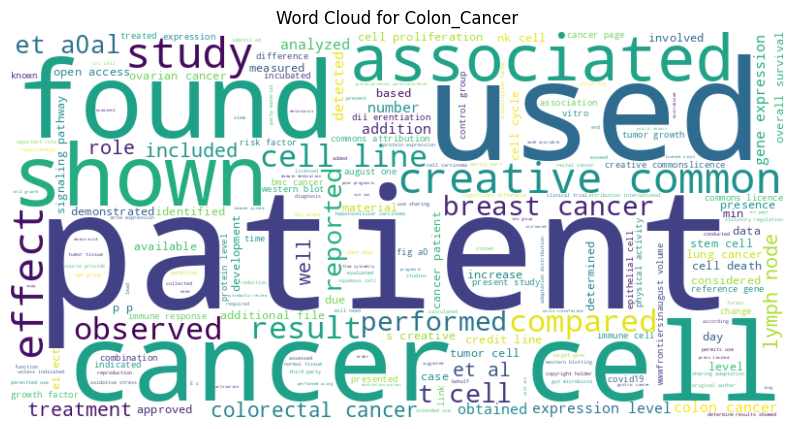

In [14]:
#Important words related to colon cancer
plot_wordcloud(data, target_column="Target", target_value="Colon_Cancer", text_column="Text")

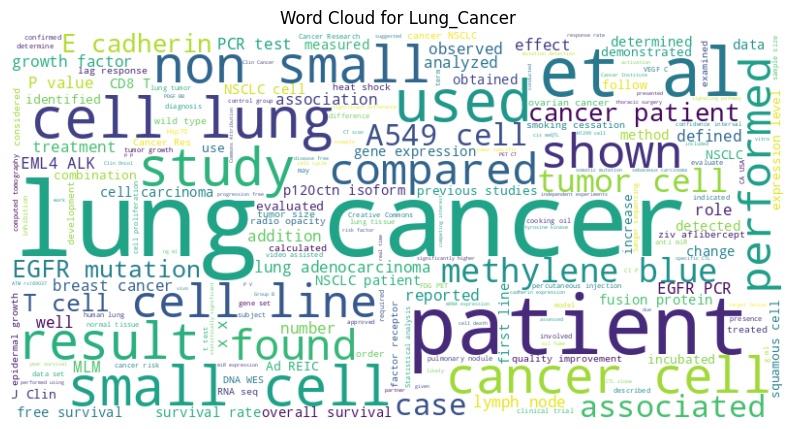

In [15]:
#Important words related to thyroid cancer
plot_wordcloud(data, target_column="Target", target_value="Lung_Cancer", text_column="Text")

##Data processing

In [16]:
#Parameters for the model
vocab_size = 20000  # Size of the vocabulary
embedding_dim = 128  # Dimension of the word embeddings
max_length = 250  # Maximum length of the sequences

#Classification of x and y
text = data["Text"].values
labels = data["Target"].values

In [18]:
#Vectorize words and pad them to sequences
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data["Text"])

sequences = tokenizer.texts_to_sequences(data["Text"])

padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [20]:
#Split dataset in train, validation and testing
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2,
                                                    random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_val, y_val, test_size=0.5,
                                                       random_state=42)

print('Train Set Shape: ', X_train.shape)
print('Validation Set Shape: ', X_valid.shape)
print('Test Set Shape: ', X_test.shape)

Train Set Shape:  (6056, 250)
Validation Set Shape:  (757, 250)
Test Set Shape:  (757, 250)


In [21]:
# Initialize the LabelEncoder
encoder = LabelEncoder()

# The encoder assigns integer values to each unique class in the target labels
y_train = encoder.fit_transform(y_train)
y_valid = encoder.transform(y_valid)
y_test = encoder.transform(y_test)

# Convert the integer-encoded labels to one-hot encoded vectors
# One-hot encoding is used for multi-class classification tasks where each class is represented as a binary vector
y_train = to_categorical(y_train, num_classes=3)
y_valid = to_categorical(y_valid, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

##Modeling

In [22]:
# Define the model
rnn_model = Sequential()
rnn_model.add(Input(shape=(max_length,)))
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
rnn_model.add(SimpleRNN(128))
rnn_model.add(Dense(3, activation='softmax'))

rnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 250, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,593,283 (9.89 MB)

 Trainable params: 2,593,283 (9.89 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#Compile the model
rnn_model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

#Set hyperparameters
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              verbose=1,
                              patience=2,
                              min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

In [26]:
#Train the model
rnn_history=rnn_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=15,
    batch_size=32,
    callbacks=callbacks)

Epoch 1/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.6604 - loss: 0.7646 - val_accuracy: 0.9762 - val_loss: 0.1197 - learning_rate: 0.0010
Epoch 2/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9813 - loss: 0.0695 - val_accuracy: 0.9749 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 3/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9863 - loss: 0.0330 - val_accuracy: 0.9828 - val_loss: 0.0493 - learning_rate: 0.0010
Epoch 4/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9890 - loss: 0.0266 - val_accuracy: 0.9841 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 5/15
190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9872 - loss: 0.0321 - val_accuracy: 0.9749 - val_loss: 0.0396 - learning_rate: 0.0010
Epoch 6/15
189/190 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9872 - loss: 0.0284
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9871 - loss: 0.

##Evaluate

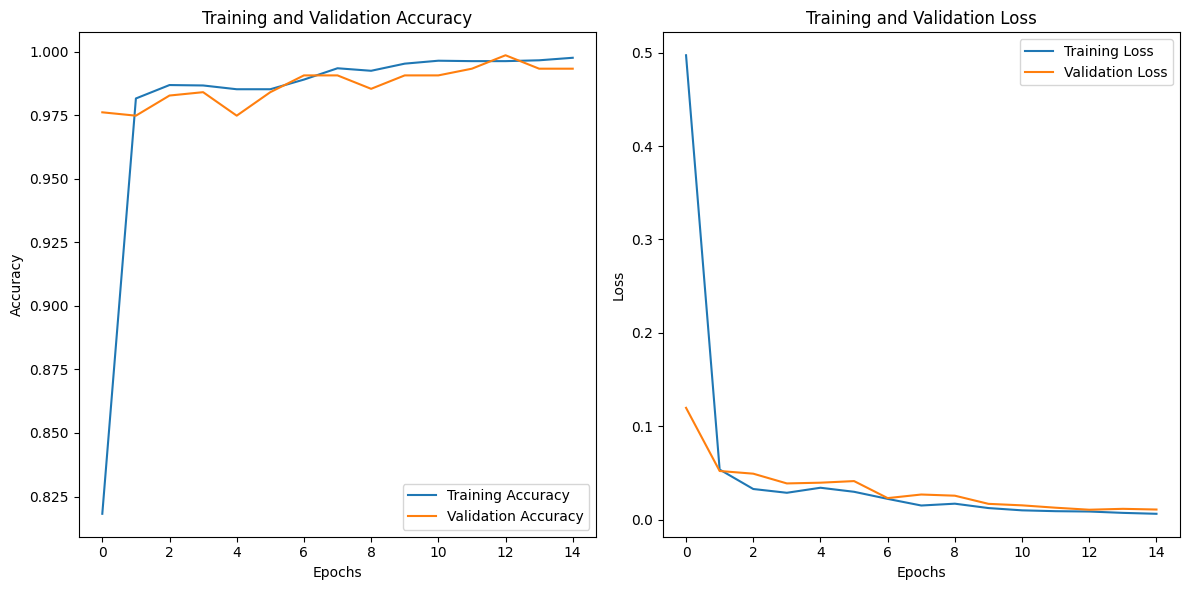

In [35]:
# Plotting the learning curve

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [37]:
#Testing the model in unseen data
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test, verbose=0)
print("RNN Loss: ", rnn_loss)
print("RNN Test Accuracy: ", rnn_accuracy)

RNN Loss:  0.007019619923084974
RNN Test Accuracy:  0.9960370063781738


In [38]:
#Classification report
class_labels = ['Thyroid_Cancer', 'Colon_Cancer', 'Lung_Cancer']
y_pred_rnn = np.argmax(rnn_model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

print(classification_report(y_true, y_pred_rnn, target_names= class_labels))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
                precision    recall  f1-score   support

Thyroid_Cancer       1.00      0.99      0.99       263
  Colon_Cancer       1.00      1.00      1.00       204
   Lung_Cancer       0.99      1.00      0.99       290

      accuracy                           1.00       757
     macro avg       1.00      1.00      1.00       757
  weighted avg       1.00      1.00      1.00       757



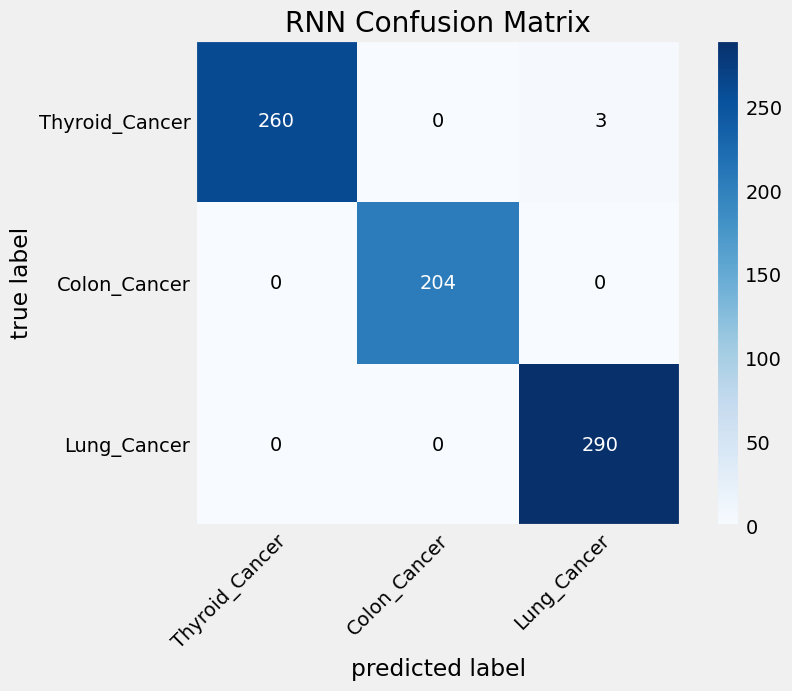

In [39]:
##Confusion matrix
conf_matrix_rnn = confusion_matrix(y_true, y_pred_rnn)

plot_confusion_matrix(conf_matrix_rnn,
                      class_names= class_labels,
                      show_normed=False,
                      figsize=(8,6),
                      colorbar=True)

plt.title('RNN Confusion Matrix')
plt.show()

In [48]:
#Closer look to the predictions after training
# Get predictions
predictions = rnn_model.predict(X_test)

# If your model outputs categorical probabilities, use argmax to get the predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

# Inverse transform to get original class labels (e.g., Lung_Cancer, Thyroid_Cancer)
predicted_labels = encoder.inverse_transform(predicted_classes)

# Show original text and predictions for the first two test samples
for i in range(2):  # Display only the first two samples
    tokenized_text = X_test[i]  # Get the tokenized (and padded) sequence

    # Convert tokenized sequence back to readable text, ignoring padding tokens
    original_text = tokenizer.sequences_to_texts([tokenized_text])[0]  # Convert to text

    # Print the original text and corresponding prediction
    print(f"Input Text: {original_text}")
    print(f"Prediction: {predicted_labels[i]}")
    print('-' * 50)  # Separator for clarity


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Input Text: substrate regulation of phosphoinositide 3 kinase clin cancer res 2011 17 206 211 12 yang x using tandem mass spectrometry in targeted mode to identify activators of class ia pi3k in cancer cancer res 2011 71 13 chen z inhibition of alk pi3k mek and in murine lung adenocarcinoma induced by eml4 alk fusion oncogene cancer res 2010 70 14 cm insights into alk driven cancers revealed through development of novel alk tyrosine kinase inhibitors cancer res 2011 71 15 r therapeutic strategies to overcome crizotinib resistance in non small cell lung cancers harboring the fusion oncogene eml4 alk proc natl acad sci u s a 2011 108 16 m acquired resistance to egfr tyrosine kinase inhibitors in cancer cells is mediated by loss of igf binding proteins j clin invest 2008 17 ab resistance to irreversible egf receptor tyrosine kinase inhibitors through a multistep mechanism involving the igf1r pathway cancer res 2013 73 18 garcia c in vivo antitumor a